# **Anomaly Detection**

---



### Loading and pre processing

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Load the dataset (replace 'anomaly_detection.csv' with your file path)
df = pd.read_csv('anomaly_detection.csv')

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

In [32]:
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5574 non-null   datetime64[ns]
 1   value    5574 non-null   int64         
 2   agency   5574 non-null   object        
 3   anomaly  5574 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 174.3+ KB


# Distribution of Anomalies in Dataset

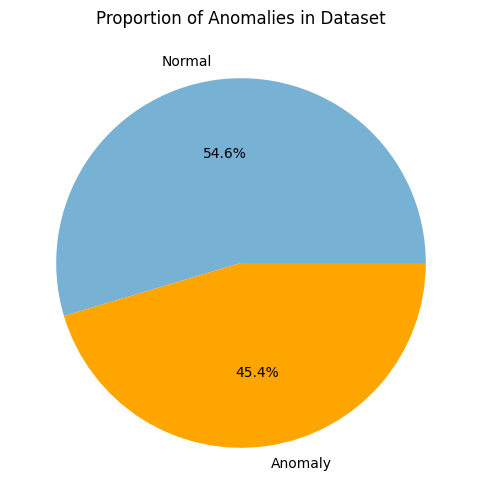

In [34]:
#Distribution of Anomalies in Dataset
plt.figure(figsize=(6, 6))
df['anomaly'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                labels=['Normal', 'Anomaly'],
                                colors=['#77B1D4', 'orange'])
plt.title('Proportion of Anomalies in Dataset')
plt.ylabel('')
plt.show()

# Values: Normal vs Anomaly

# Total Anomalies by Agency

  agency  anomaly
0    AAA      843
1    BBB      843
2    CCC      843


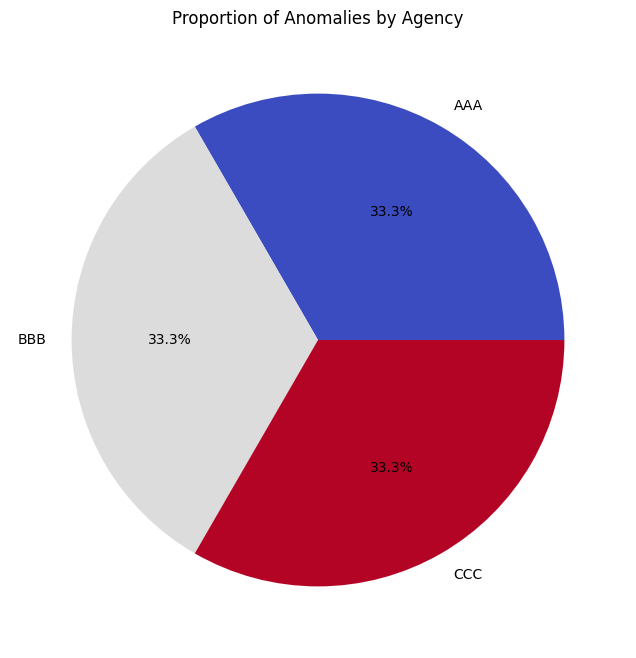

In [35]:
# Group by agency and count anomalies
anomalies_by_agency = df.groupby('agency')['anomaly'].sum().reset_index()

# Sort for better visualization
anomalies_by_agency = anomalies_by_agency.sort_values(by='anomaly', ascending=False)

# Display the aggregated data
print(anomalies_by_agency)

anomalies_by_agency.set_index('agency')['anomaly'].plot(kind='pie', autopct='%1.1f%%', figsize=(8,8), cmap='coolwarm')
plt.title("Proportion of Anomalies by Agency")
plt.ylabel("")  # Hide y-label
plt.show()


### All the agencies have same number of anomalies in this dataset.

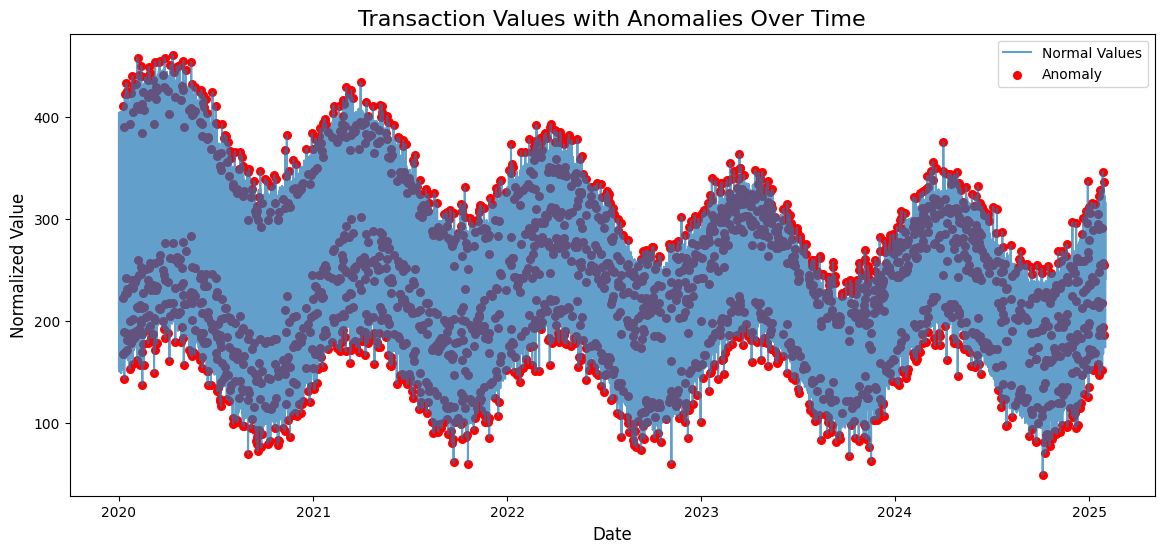

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['value'], label='Normal Values', alpha=0.7)
plt.scatter(df[df['anomaly']==1]['date'], df[df['anomaly']==1]['value'],
            color='red', label='Anomaly', s=30)
plt.title('Transaction Values with Anomalies Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.show()

# Transaction Values with Anomalies Over Time

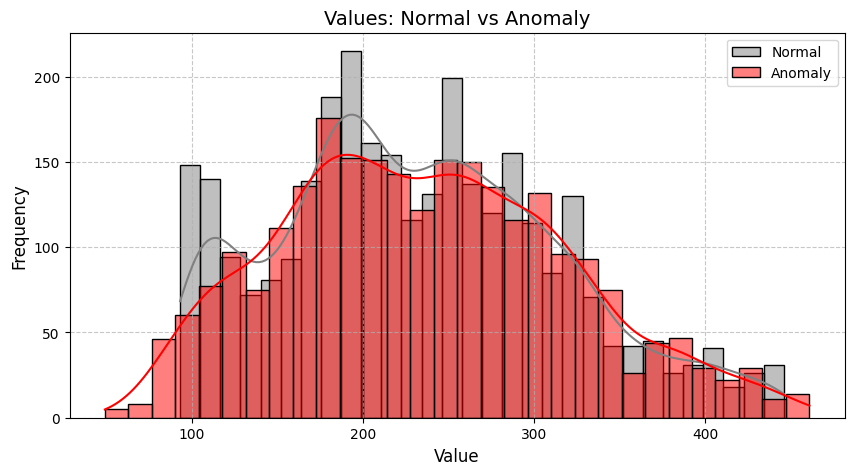

In [37]:
#Value Distribution: Normal vs. Anomaly Comparison
plt.figure(figsize=(10, 5))
sns.histplot(df[df['anomaly'] == 0]['value'], bins=30, color='gray', label='Normal', kde=True)
sns.histplot(df[df['anomaly'] == 1]['value'], bins=30, color='red', label='Anomaly', kde=True)
plt.title('Values: Normal vs Anomaly', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Feature Engineering

In [38]:
# One-hot encoding 'agency'
agency_dummies = pd.get_dummies(df['agency'], prefix='agency')
df = pd.concat([df, agency_dummies], axis=1)

df = df.astype({'agency_AAA': 'int64', 'agency_BBB': 'int64','agency_CCC': 'int64'})

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to the 'value' column
df['value_minmax'] = scaler.fit_transform(df[['value']])

In [40]:
# Extracting date-based features
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [41]:
# Seasonality
df['quarter'] = df['date'].dt.quarter

In [42]:
# Lag Feature
df['lag_1'] = df['value_minmax'].shift(1)  # Value at t-1


In [43]:
# Computing rolling mean per agency (grouped and sorted)
df.sort_values(['agency', 'date'], inplace=True)
df['value_rolling_mean_7'] = df.groupby('agency')['value_minmax'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

# Sort the entire dataset by date for time-series split
df.sort_values('date', inplace=True)

In [44]:
# Calculating deviation from rolling mean
df['value_deviation'] = df['value_minmax'] - df['value_rolling_mean_7']

#Rolling Standard Deviation
df['value_rolling_std_7'] = df.groupby('agency')['value_minmax'].transform(
    lambda x: x.rolling(7, min_periods=1).std()
)

# Z-score for anomalies
df['value_zscore'] = (df['value_minmax'] - df['value_rolling_mean_7']) / df['value_rolling_std_7']
df.head()

,date,value,agency,anomaly,agency_AAA,agency_BBB,agency_CCC,value_minmax,day_of_week,month,is_weekend,quarter,lag_1,value_rolling_mean_7,value_deviation,value_rolling_std_7,value_zscore
0,2020-01-01,197,AAA,0,1,0,0,0.359223,2,1,0,1,NaN,0.359223,0.000000,NaN,NaN
1,2020-01-01,404,CCC,0,0,0,1,0.861650,2,1,0,1,0.359223,0.861650,0.000000,NaN,NaN
2,2020-01-01,153,BBB,0,0,1,0,0.252427,2,1,0,1,0.861650,0.252427,0.000000,NaN,NaN
3,2020-01-02,205,AAA,0,1,0,0,0.378641,3,1,0,1,0.252427,0.368932,0.009709,0.013730,0.707107
4,2020-01-02,401,CCC,0,0,0,1,0.854369,3,1,0,1,0.378641,0.858010,-0.003641,0.005149,-0.707107


In [45]:
import pandas as pd

# One-hot encode 'day_of_week', 'month', and 'quarter'
df = pd.get_dummies(
    df,
    columns=['day_of_week', 'quarter'],
    prefix=['dow', 'qtr'],
    drop_first=False
)
df = df.astype({'dow_0':'int64','dow_1':'int64', 'dow_2':'int64', 'dow_3':'int64','dow_4':'int64', 'dow_5':'int64', 'dow_6':'int64', 'qtr_1':'int64','qtr_2':'int64', 'qtr_3':'int64', 'qtr_4':'int64'})
# Select all boolean columns and convert them to int
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype('int')

# Display the updated DataFrame
df.fillna(0, inplace=True)
df.head()

,date,value,agency,anomaly,agency_AAA,agency_BBB,agency_CCC,value_minmax,month,is_weekend,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,qtr_1,qtr_2,qtr_3,qtr_4
0,2020-01-01,197,AAA,0,1,0,0,0.359223,1,0,...,0,1,0,0,0,0,1,0,0,0
1,2020-01-01,404,CCC,0,0,0,1,0.861650,1,0,...,0,1,0,0,0,0,1,0,0,0
2,2020-01-01,153,BBB,0,0,1,0,0.252427,1,0,...,0,1,0,0,0,0,1,0,0,0
3,2020-01-02,205,AAA,0,1,0,0,0.378641,1,0,...,0,0,1,0,0,0,1,0,0,0
4,2020-01-02,401,CCC,0,0,0,1,0.854369,1,0,...,0,0,1,0,0,0,1,0,0,0


# Quarterly Anomaly Analysis

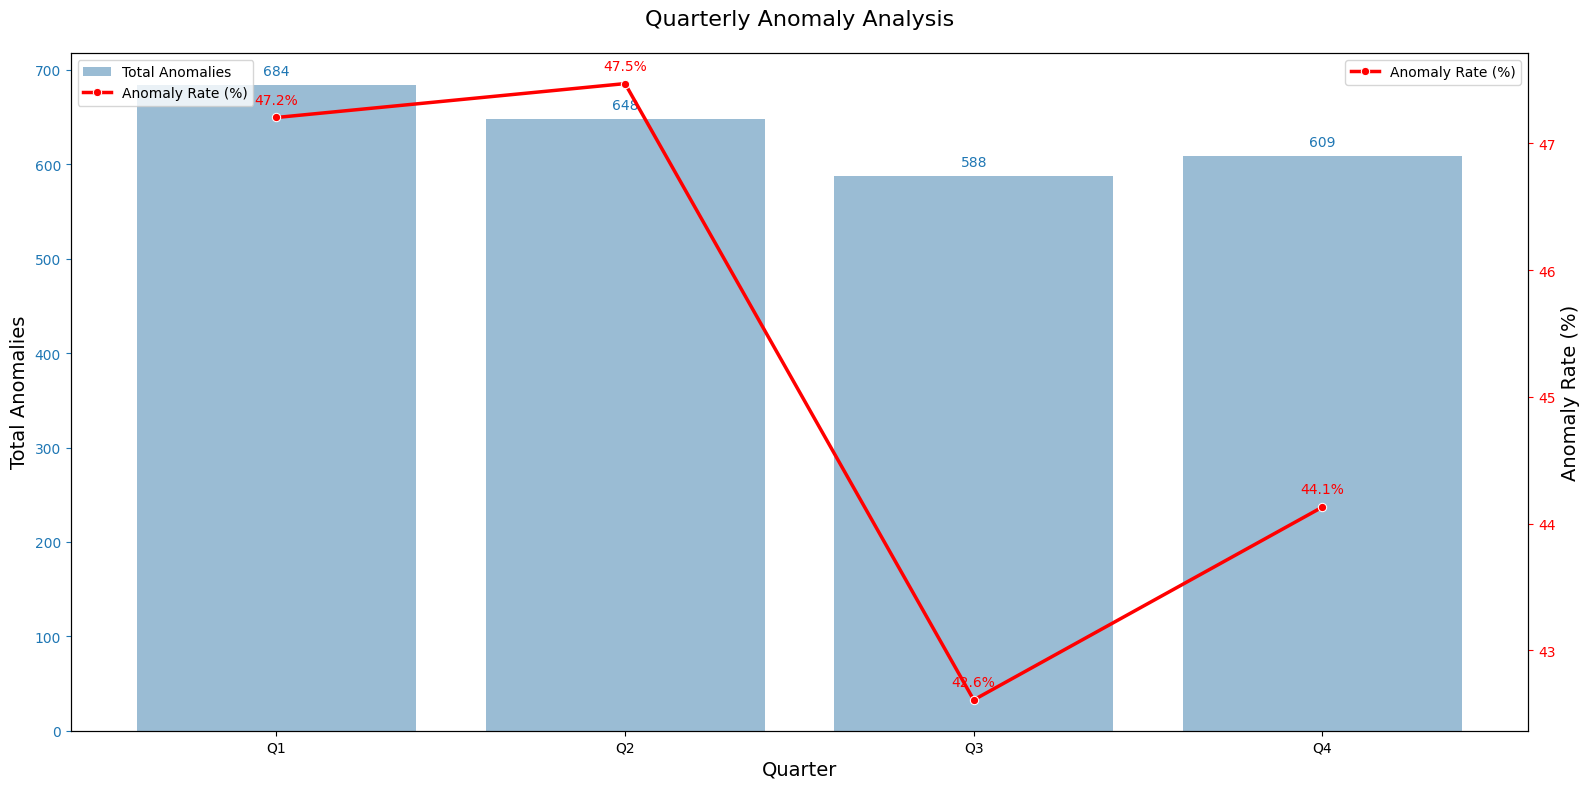

In [46]:
#  Extracting Quarter from Date
df['Quarter'] = df['date'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})

# Calculating Anomaly Rate
quarterly_data = df.groupby('Quarter')['anomaly'].agg(['mean', 'sum']).reset_index()
quarterly_data['mean'] = quarterly_data['mean'] * 100  # Convert to percentage

# Creating Visualization
fig, ax = plt.subplots(figsize=(16,8))

# Bar plot for total anomalies
sns.barplot(
    x='Quarter',
    y='sum',
    data=quarterly_data,
    color='#90bede',
    label='Total Anomalies',
    ax=ax
)

# Line plot for anomaly rate
ax2 = ax.twinx()
sns.lineplot(
    x='Quarter',
    y='mean',
    data=quarterly_data,
    color='red',
    marker='o',
    linewidth=2.5,
    label='Anomaly Rate (%)',
    ax=ax2
)

ax.set_title('Quarterly Anomaly Analysis', fontsize=16, pad=20)
ax.set_xlabel('Quarter', fontsize=14)
ax.set_ylabel('Total Anomalies', fontsize=14)
ax2.set_ylabel('Anomaly Rate (%)', fontsize=14)
ax.tick_params(axis='y', colors='#1f77b4')
ax2.tick_params(axis='y', colors='red')

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                color='#1f77b4')

for x,y in zip(quarterly_data['Quarter'], quarterly_data['mean']):
    ax2.annotate(f'{y:.1f}%',
                 (x, y),
                 textcoords='offset points',
                 xytext=(0,10),
                 ha='center',
                 color='red')

# Combining the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

## Blue Bars:
### The height of the blue bars shows the total number of anomalies detected in each quarter. **Q1 has the most anomalies overall(684)**."

## Red Line:
### The red line shows the percentage of transactions flagged as anomalies.

### Even though Q1 has the most total anomalies, **Q2 actually has the highest rate of anomalies** relative to its total values.

# Anomalies by Day of Week

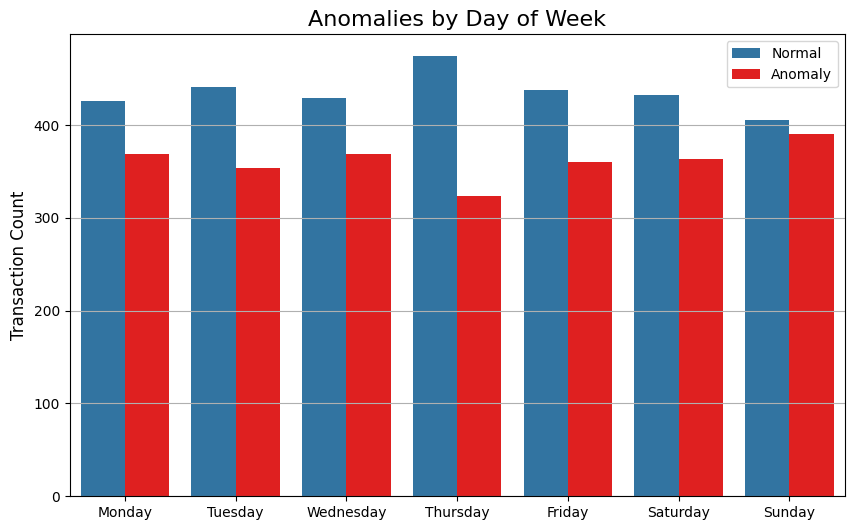

In [47]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['date'].dt.day_name(), hue=df['anomaly'],
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              palette={0:'#1f77b4', 1:'red'})
plt.grid(axis='y')
plt.title('Anomalies by Day of Week', fontsize=16)
plt.xlabel('')
plt.ylabel('Transaction Count', fontsize=12)
plt.legend(title='', labels=['Normal', 'Anomaly'])
plt.show()

## The graph compares normal transactions (blue bars) and anomalous transactions (red bars) across different days of the week.

## **Thursday has the highest number of normal transactions**, while **Sunday has the lowest.**

## **Anomalous transactions** appear to be relatively stable throughout the week but are **slightly lower on Thursday and Tuesday.**

Feature Importance

<ipython-input-48-a7fb6d332565>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


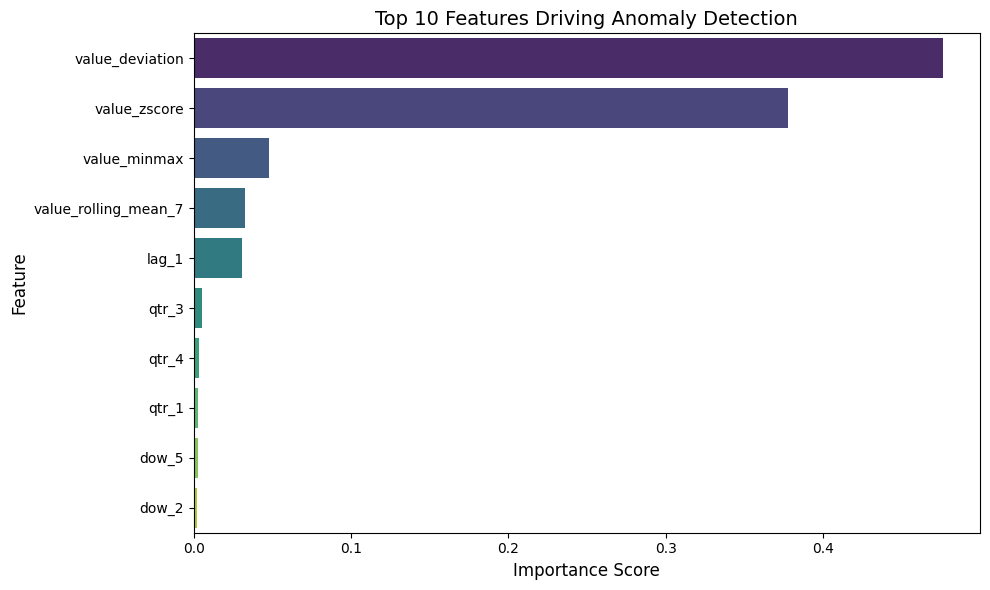

In [48]:
# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})\
                     .sort_values('Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Top 10 Features Driving Anomaly Detection", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Time Series of Values by Agency

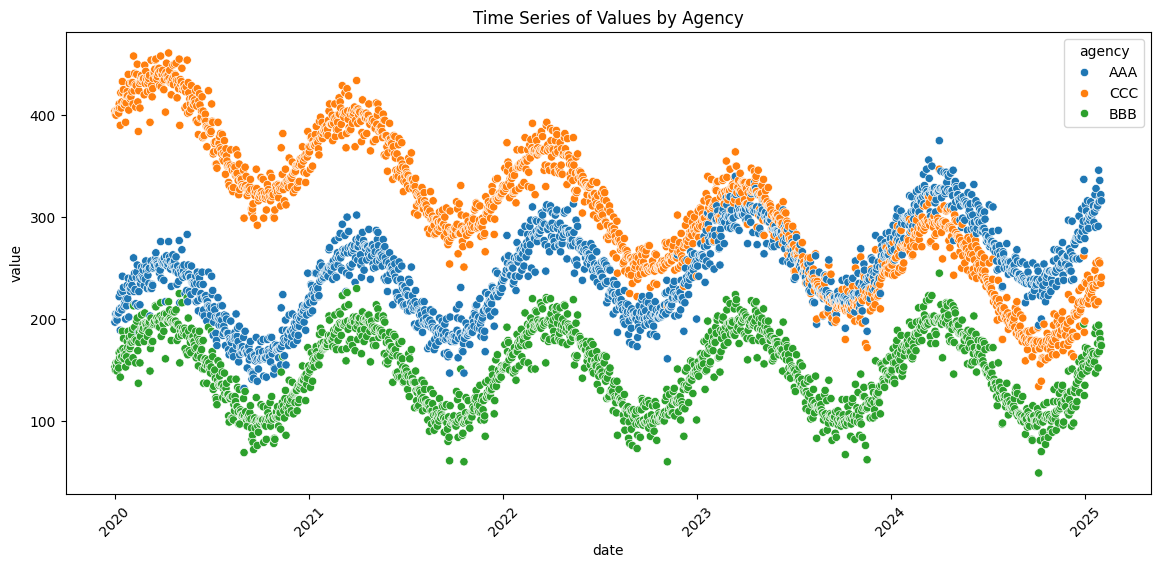

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14,6))
sns.scatterplot(data=df, x='date', y='value', hue='agency')
plt.title("Time Series of Values by Agency")
plt.xticks(rotation=45)
plt.show()


# This graph represents AAA - Values vs 7-Day Average (Anomalies Marked) over time.

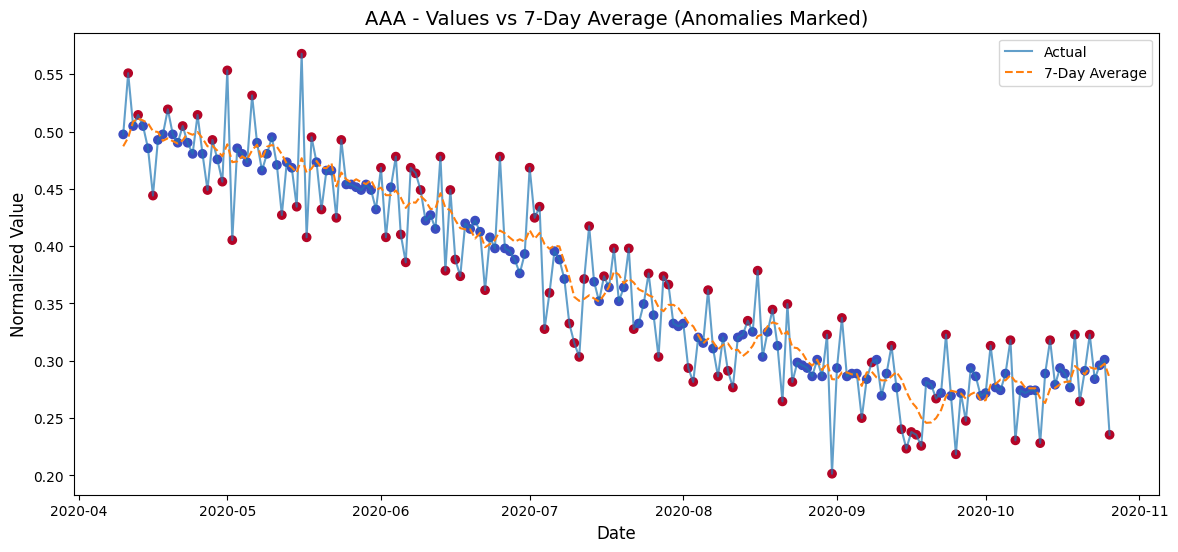

In [50]:
agency_sample = 'AAA'  # Pick one agency
sample_df = df[df['agency']==agency_sample].iloc[100:300]  # 100-day window

plt.figure(figsize=(14,6))
plt.plot(sample_df['date'], sample_df['value_minmax'], label='Actual', alpha=0.7)
plt.plot(sample_df['date'], sample_df['value_rolling_mean_7'],
         label='7-Day Average', linestyle='--')
plt.scatter(sample_df['date'], sample_df['value_minmax'],
            c=sample_df['anomaly'], cmap='coolwarm')
plt.title(f'{agency_sample} - Values vs 7-Day Average (Anomalies Marked)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.show()


### The 7-day average helps in identifying the underlying trend despite daily fluctuations.

### The blue line represents the actual values over time.

### The orange dashed line represents the 7-day moving average.

### Red dots indicate anomalies—values that deviate significantly from the expected trend.

# This graph represents AAA - Values vs 7-Day Average (Anomalies Marked) over a longer period of time.

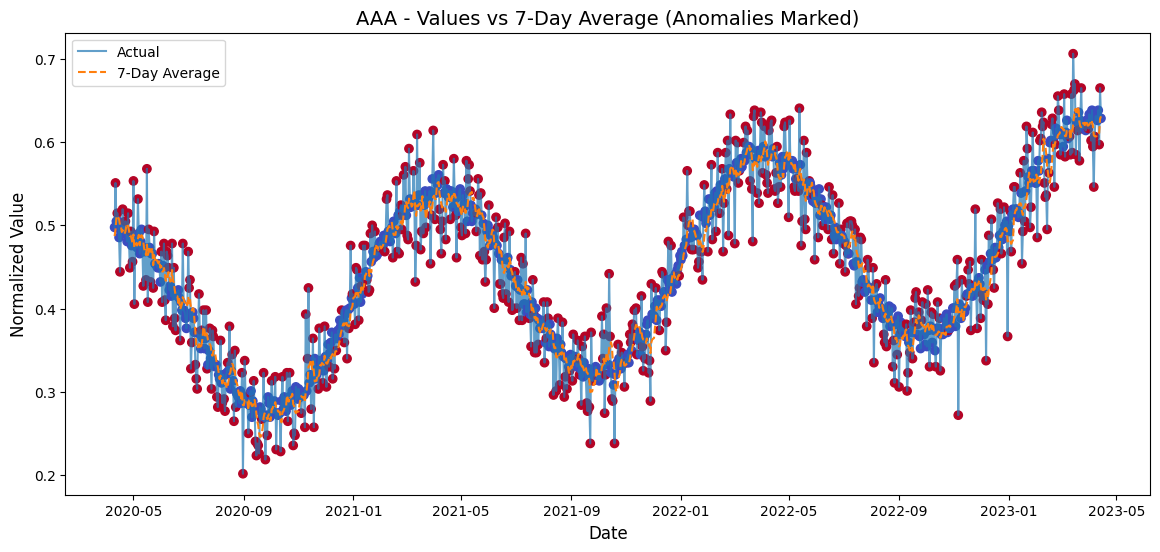

In [51]:
agency_sample = 'AAA'  # Pick one agency
sample_df = df[df['agency']==agency_sample].iloc[100:1200]  # 100-day window

plt.figure(figsize=(14,6))
plt.plot(sample_df['date'], sample_df['value_minmax'], label='Actual', alpha=0.7)
plt.plot(sample_df['date'], sample_df['value_rolling_mean_7'],
         label='7-Day Average', linestyle='--')
plt.scatter(sample_df['date'], sample_df['value_minmax'],
            c=sample_df['anomaly'], cmap='coolwarm')
plt.title(f'{agency_sample} - Values vs 7-Day Average (Anomalies Marked)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.show()

## **High Values (Peaks):**

### Around **March to June** of each year, the values are at their highest.

## **Low Values (Troughs):**

### Around **September to December**, the values are at their lowest.

### The values increase during the first half of the year (spring to summer) and decrease in the second half (fall to winter).

# This graph represents BBB - Values vs 7-Day Average (Anomalies Marked) over a longer period of time.


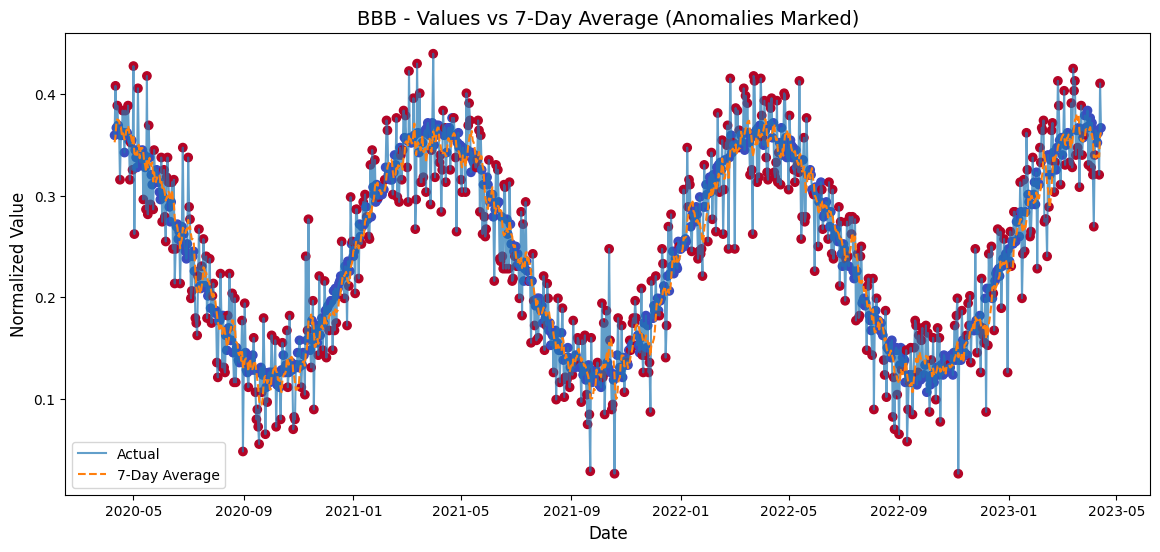

In [52]:
agency_sample = 'BBB'  # Pick one agency
sample_df = df[df['agency']==agency_sample].iloc[100:1200]  # 100-day window

plt.figure(figsize=(14,6))
plt.plot(sample_df['date'], sample_df['value_minmax'], label='Actual', alpha=0.7)
plt.plot(sample_df['date'], sample_df['value_rolling_mean_7'],
         label='7-Day Average', linestyle='--')
plt.scatter(sample_df['date'], sample_df['value_minmax'],
            c=sample_df['anomaly'], cmap='coolwarm')
plt.title(f'{agency_sample} - Values vs 7-Day Average (Anomalies Marked)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.show()

### The values are **highest around January to May** each year.

### The values are **lowest around August to October** each year.

# This graph represents CCC - Values vs 7-Day Average (Anomalies Marked) over a longer period of time.

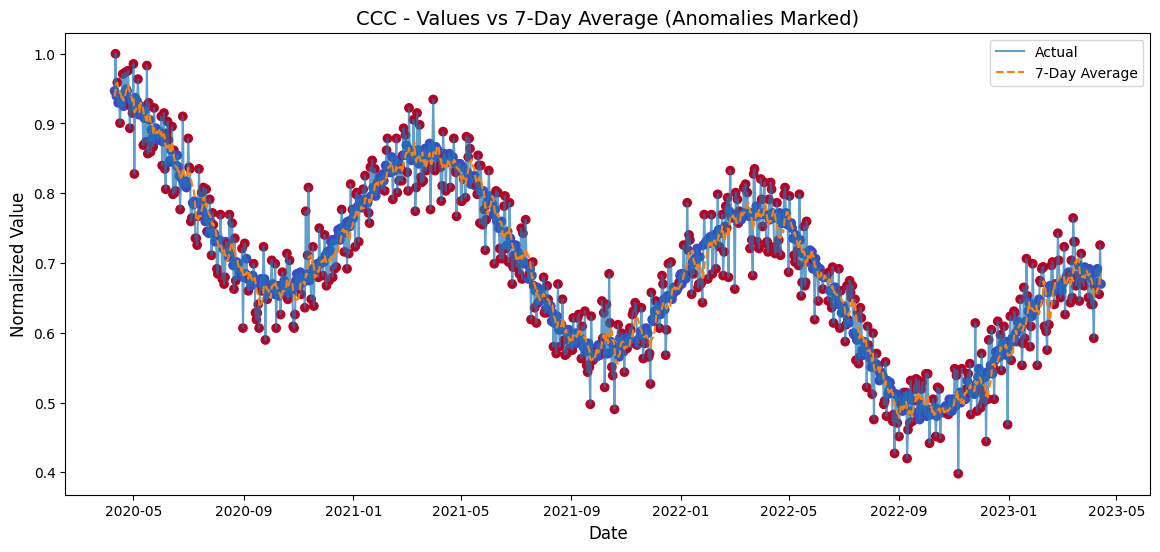

In [53]:
agency_sample = 'CCC'  # Pick one agency
sample_df = df[df['agency']==agency_sample].iloc[100:1200]  # 100-day window

plt.figure(figsize=(14,6))
plt.plot(sample_df['date'], sample_df['value_minmax'], label='Actual', alpha=0.7)
plt.plot(sample_df['date'], sample_df['value_rolling_mean_7'],
         label='7-Day Average', linestyle='--')
plt.scatter(sample_df['date'], sample_df['value_minmax'],
            c=sample_df['anomaly'], cmap='coolwarm')
plt.title(f'{agency_sample} - Values vs 7-Day Average (Anomalies Marked)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.show()

### The values are **highest around March to May** each year.


### The values are **lowest around August to October** each year.

In [54]:
print(df.columns)

Index(['date', 'value', 'agency', 'anomaly', 'agency_AAA', 'agency_BBB',
       'agency_CCC', 'value_minmax', 'month', 'is_weekend', 'lag_1',
       'value_rolling_mean_7', 'value_deviation', 'value_rolling_std_7',
       'value_zscore', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5',
       'dow_6', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'Quarter'],
      dtype='object')


# **Model Training (Random Forest)**

In [55]:
features = ['agency_AAA', 'agency_BBB', 'agency_CCC', 'value_minmax',
           'is_weekend', 'lag_1', 'value_rolling_mean_7','dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5',
       'dow_6', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4',
           'value_deviation', 'value_zscore']

train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df[features]
y_train = train_df['anomaly']
X_test = test_df[features]
y_test = test_df['anomaly']

In [56]:
# Initialize and train the model
rf = RandomForestClassifier(
    max_depth=8,           # Restrict tree depth
    min_samples_split=10,   # Require 10 samples to split a node
    class_weight={0: 1, 1: 2},
    n_estimators=200,
    random_state=42,
    max_features='sqrt',  # Use sqrt(n_features) instead of all
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=8,
                       min_samples_split=10, n_estimators=200, random_state=42)

In [57]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8,10],
    'min_samples_split': [8, 10],
    'class_weight': [{0: 1, 1: 2}]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [8,10],\n    'min_samples_split': [8, 10],\n    'class_weight': [{0: 1, 1: 2}]\n}\n\ngrid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')\ngrid_search.fit(X_train, y_train)\nbest_model = grid_search.best_estimator_"

Accuracy: 0.8278026905829596

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       629
           1       0.80      0.81      0.80       486

    accuracy                           0.83      1115
   macro avg       0.82      0.83      0.83      1115
weighted avg       0.83      0.83      0.83      1115



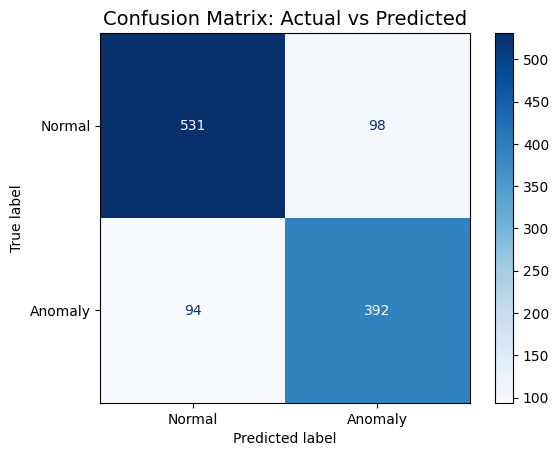

In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Predict on test data
y_pred = rf.predict(X_test)

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report (Precision, Recall, F1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted', fontsize=14)
plt.show()

## **Overall Accuracy:**

### The model achieved an accuracy of **82.78%** on the test set, which indicates a good predictive performance.

### The model performs slightly better for normal cases (Class 0) than for anomalies (Class 1), as seen in the higher precision, recall, and F1-score for normal cases.

### Confusion Matrix:

### **True Negatives (531)**: These are normal cases that were correctly classified.

### **True Positives (392):** These are anomaly cases that were correctly identified.

### **False Positives (94):** The model incorrectly flagged 94 normal cases as anomalies, which could be a concern for false alarms.

### **False Negatives (98):** The model missed 98 actual anomalies, meaning these were mistakenly classified as normal.

# **Training vs Test Accuracy**

Training Accuracy: 0.86
Test Accuracy: 0.83


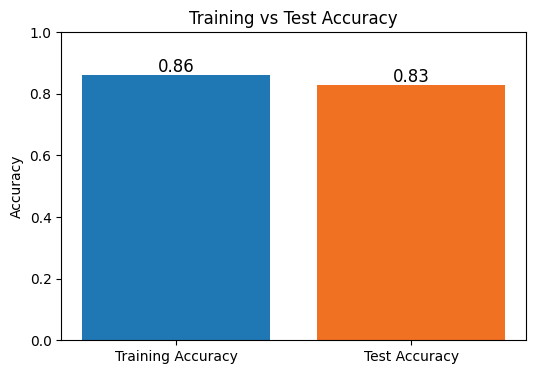

In [59]:
# Train the model
rf.fit(X_train, y_train)

# Evaluate on training data
train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate on test data
test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

import matplotlib.pyplot as plt

# Accuracy values
accuracies = [train_accuracy, test_accuracy]
labels = ['Training Accuracy', 'Test Accuracy']

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['#1f77b4', '#f07122'])

# Add value labels on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12)

# Labels and title
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.title('Training vs Test Accuracy')
plt.show()


## **Training Accuracy = 86%, Test Accuracy = 83%** -> Indicates mild overfitting, but the model is generalizing well.

# **ROC Curve for Training and Test Sets**

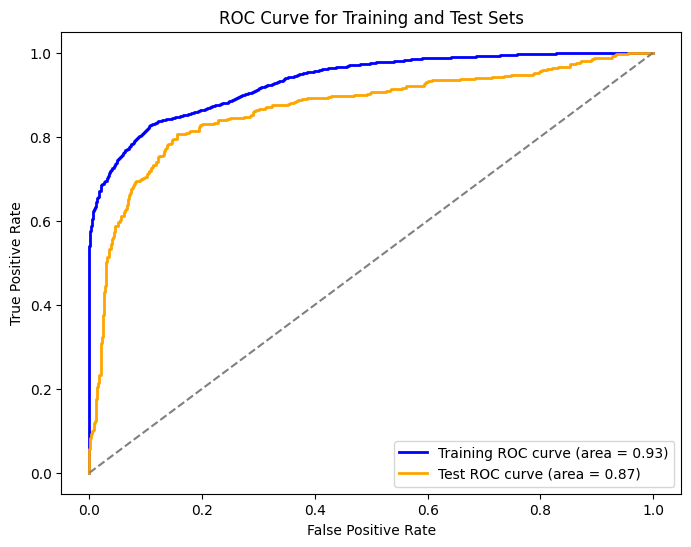

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
train_probs = rf.predict_proba(X_train)[:, 1]
test_probs = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

# Compute AUC (Area Under the Curve)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='orange', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training and Test Sets')
plt.legend(loc='lower right')
plt.show()


### The drop in AUC from training to test suggests some overfitting, where the model performs better on training data than test data.

### The test AUC of 0.87 is still strong, indicating that the model has good discrimination power between normal and anomaly cases.

# Conclusions:

### The model achieved a training accuracy of 86% and a test accuracy of 83%, indicating good generalization with minimal overfitting.
### The confusion matrix shows a balanced performance, with an overall precision of 80% for anomalies and a recall of 81%, ensuring that most actual anomalies are detected while maintaining a reasonable false positive rate. The F1-score of 80% for anomalies confirms that the model strikes an effective balance between precision and recall.
### In anomaly detection, there is an inherent tradeoff maximizing precision would miss too many anomalies (low recall), while maximizing recall would flag too many normal cases as anomalies (low precision).